In [40]:
!pip install pyspark


In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [42]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [43]:
dataset = spark.read.csv('/content/gdrive/MyDrive/Dataset/dataset.csv', header=True, inferSchema=True)


In [44]:
# Chia khoảng để thực hiện bài toán phân lớp ta có
# ARR_DELAY <= 0 nghĩa là xuất phát sớm hoặc đúng giờ ta gán nhãn 0
# 0 < ARR_DELAY <= 20 trễ không quá 20 phút ta gán 1
# ARR_DELAY > 20 trễ quá 20 phút ta gán 2
from pyspark.sql import functions as F

# Giả sử df là DataFrame và cột 'distance' chứa giá trị khoảng cách
dataset = dataset.withColumn('LABEL',
                  F.when(dataset['ARR_DELAY'] <= 0, 0)
                   .when((dataset['ARR_DELAY'] > 0) & (dataset['ARR_DELAY'] <= 20), 1)
                   .otherwise(2))
dataset = dataset.drop('ARR_DELAY')

In [45]:
dataset.printSchema()

root
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEP_TIME: integer (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- LABEL: integer (nullable = false)



In [46]:
dataset = dataset.dropna()
dataset.show(10,False)
dataset.describe().show()
dataset.count()

+------------+-----------+-----------------+-----------------+------+----+--------+--------+----------+--------+-----+
|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|DEP_TIME|TAXI_OUT|WHEELS_OFF|DISTANCE|LABEL|
+------------+-----------+-----------------+-----------------+------+----+--------+--------+----------+--------+-----+
|1           |1          |9E               |4800             |CHS   |JFK |656     |14.0    |710       |636.0   |0    |
|1           |1          |9E               |4801             |ATL   |TRI |2056    |46.0    |2142      |227.0   |1    |
|1           |1          |9E               |4802             |FSD   |MSP |1113    |25.0    |1138      |196.0   |1    |
|1           |1          |9E               |4802             |MSP   |FSD |902     |26.0    |928       |196.0   |0    |
|1           |1          |9E               |4803             |TRI   |ATL |555     |21.0    |616       |227.0   |0    |
|1           |1          |9E               |4804

616282

In [48]:
distinct_counts = []
for col in dataset.columns:
    distinct_counts.append((col, dataset.select(col).distinct().count()))

result = spark.createDataFrame(distinct_counts, ['column', 'distinct_count']).sort('distinct_count')

result.show()

+-----------------+--------------+
|           column|distinct_count|
+-----------------+--------------+
|            LABEL|             3|
|      DAY_OF_WEEK|             7|
|OP_UNIQUE_CARRIER|            15|
|     DAY_OF_MONTH|            31|
|         TAXI_OUT|           178|
|           ORIGIN|           342|
|             DEST|           342|
|         DEP_TIME|          1422|
|       WHEELS_OFF|          1423|
|         DISTANCE|          1514|
|OP_CARRIER_FL_NUM|          6288|
+-----------------+--------------+



In [49]:
import pyspark.pandas as ps
import matplotlib.pyplot as plt

def pie_Plot_By_Col(dataset,columnName):
  df_P = (dataset.select(columnName)).groupBy(columnName).count()
  df_P.toPandas().set_index(columnName)['count'].plot.pie(autopct='%1.1f%%', startangle=90)
  plt.title('Biểu đồ tương quan các giá trị '+columnName)
  plt.ylabel('')
  plt.show()


In [50]:

def bar_Plot_By_Col(dataset,columnName):
  df_P = (dataset.select(columnName)).groupBy(columnName).count().sort('count')
  df_P.show()
  df_P.toPandas().plot.bar(x=columnName, y='count')


In [51]:
def histogram_Plot_By_Col(dataset, columnName, bins=30):
    pdf = dataset.select(columnName).toPandas()
    values = pdf[columnName]

    # Vẽ biểu đồ histogram
    plt.figure(figsize=(12, 8))
    plt.hist(values, bins=bins, color='#00BFFF', edgecolor='black')

    # Thêm nhãn và tiêu đề
    plt.xlabel(columnName, fontsize=15, fontfamily='serif')
    plt.ylabel('Frequency', fontsize=15, fontfamily='serif')
    plt.title(f'Tương quan giá trị của cột {columnName}', fontsize=18, fontfamily='serif')

    # Hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

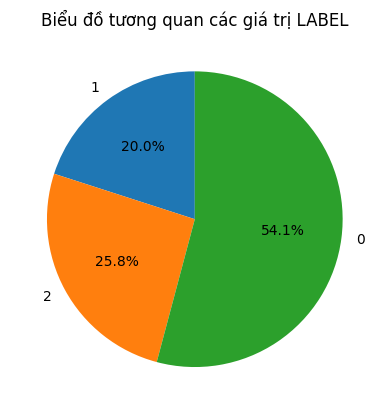

+-----+------+
|LABEL| count|
+-----+------+
|    1|123424|
|    2|159174|
|    0|333684|
+-----+------+



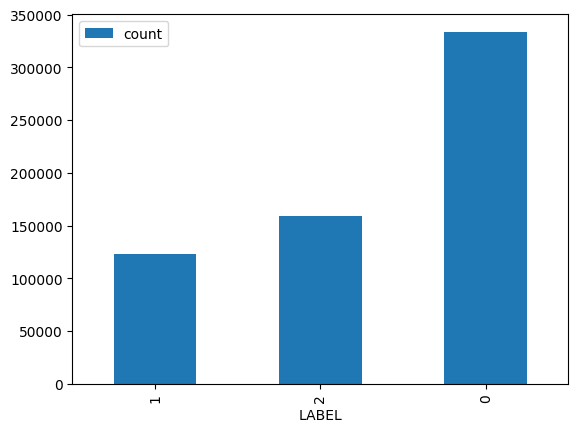

In [52]:
pie_Plot_By_Col(dataset,'LABEL')
bar_Plot_By_Col(dataset,'LABEL')

+-----------+------+
|DAY_OF_WEEK| count|
+-----------+------+
|          6| 74248|
|          5| 79351|
|          4| 79915|
|          7| 81323|
|          2| 98786|
|          3|100479|
|          1|102180|
+-----------+------+



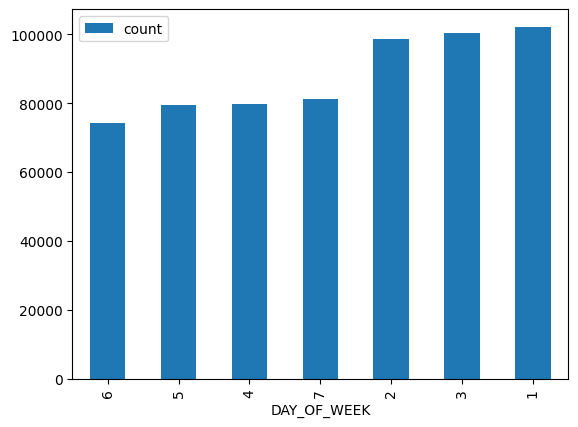

In [53]:
bar_Plot_By_Col(dataset,'DAY_OF_WEEK')


+-----------------+------+
|OP_UNIQUE_CARRIER| count|
+-----------------+------+
|               HA|  6765|
|               G4| 12446|
|               9E| 15871|
|               F9| 18554|
|               OH| 19306|
|               B6| 19949|
|               NK| 23491|
|               AS| 23671|
|               YX| 24894|
|               MQ| 25834|
|               UA| 63017|
|               OO| 63359|
|               AA| 86084|
|               DL| 86244|
|               WN|126797|
+-----------------+------+



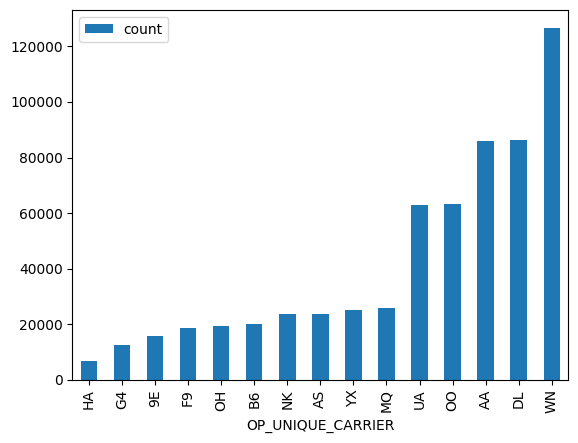

In [54]:
bar_Plot_By_Col(dataset,'OP_UNIQUE_CARRIER')


+------------+-----+
|DAY_OF_MONTH|count|
+------------+-----+
|           4|16924|
|          20|17124|
|          19|17922|
|           5|18900|
|           6|18985|
|          21|18986|
|          13|19013|
|          27|19126|
|          23|19243|
|          17|19554|
|          22|19669|
|           2|19671|
|          16|19906|
|           9|19959|
|          30|20007|
|           1|20025|
|          24|20077|
|          10|20155|
|          31|20212|
|           8|20254|
+------------+-----+
only showing top 20 rows



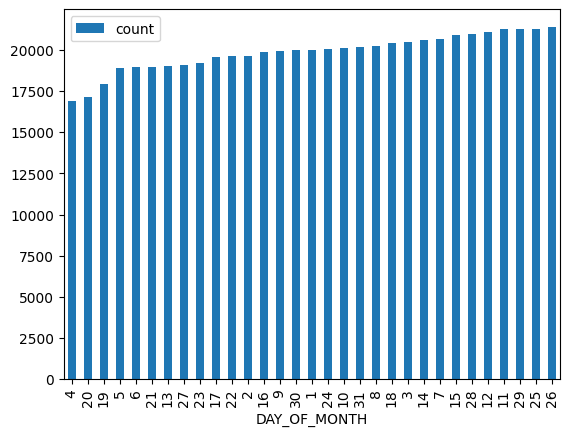

In [55]:

bar_Plot_By_Col(dataset,'DAY_OF_MONTH')


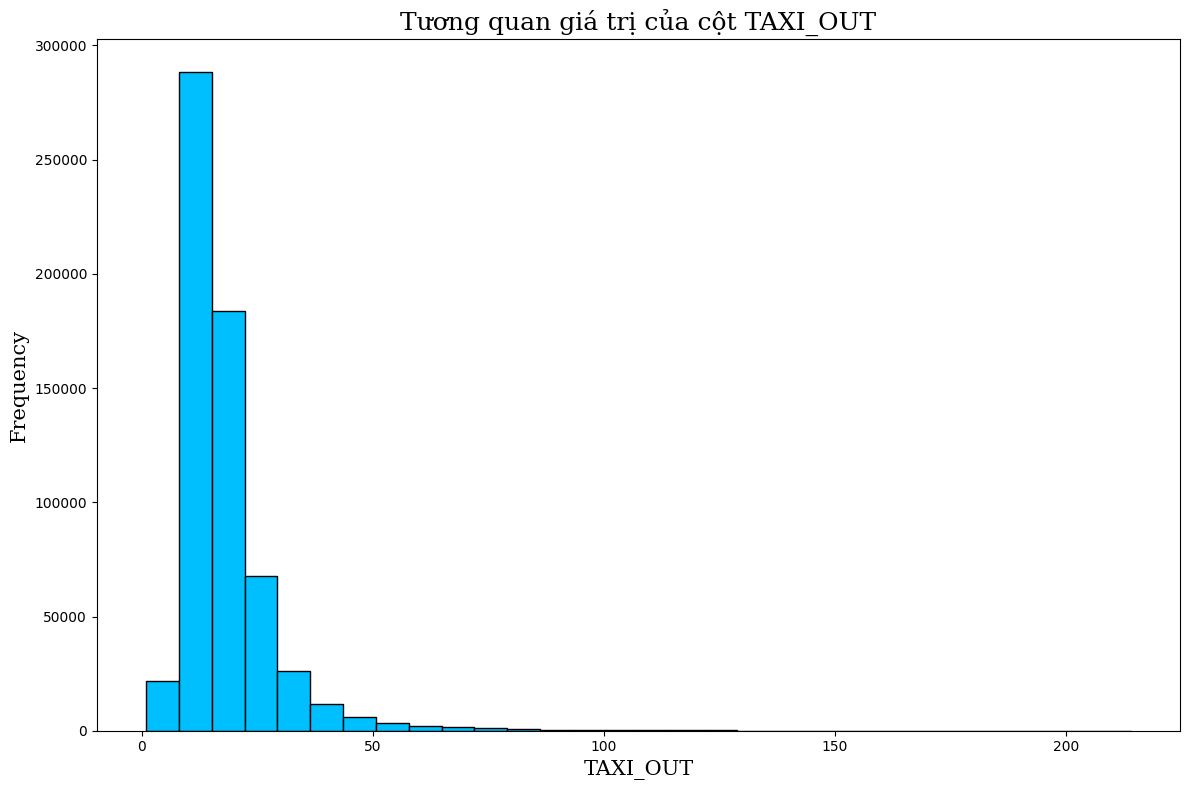

In [56]:
histogram_Plot_By_Col(dataset,'TAXI_OUT')

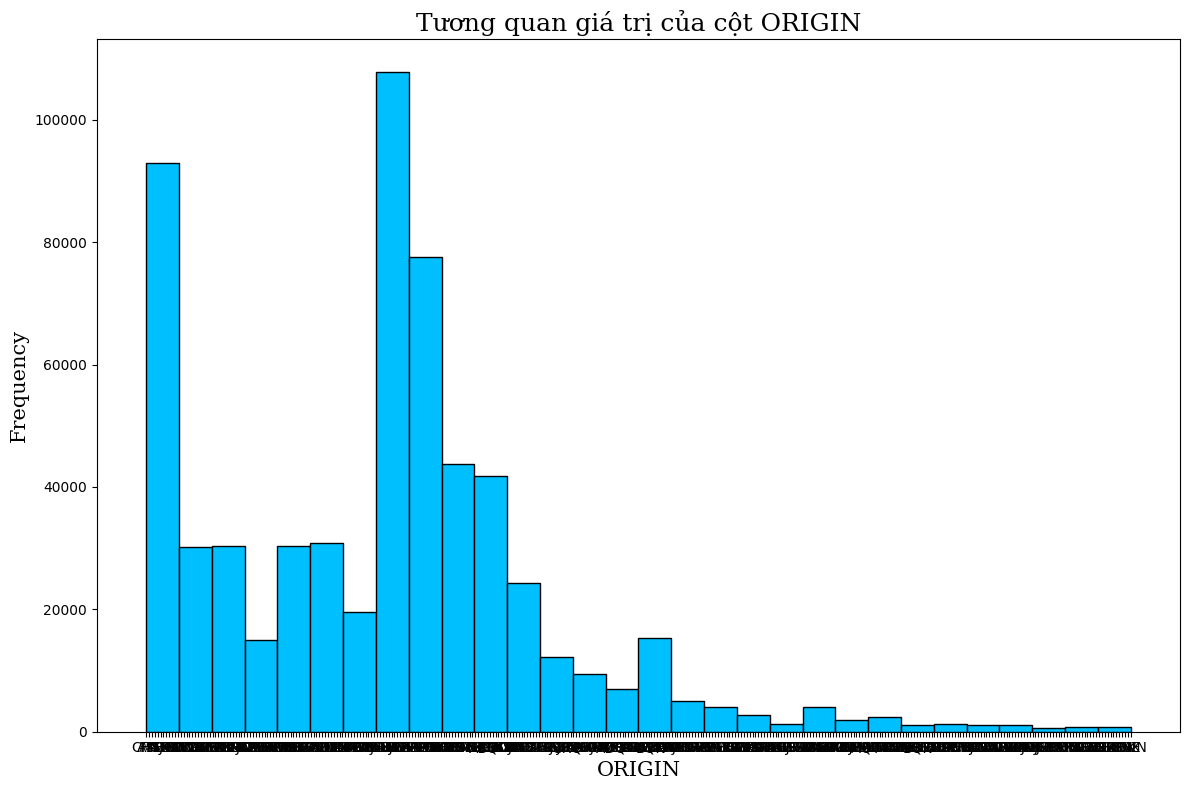

In [57]:
histogram_Plot_By_Col(dataset,'ORIGIN')

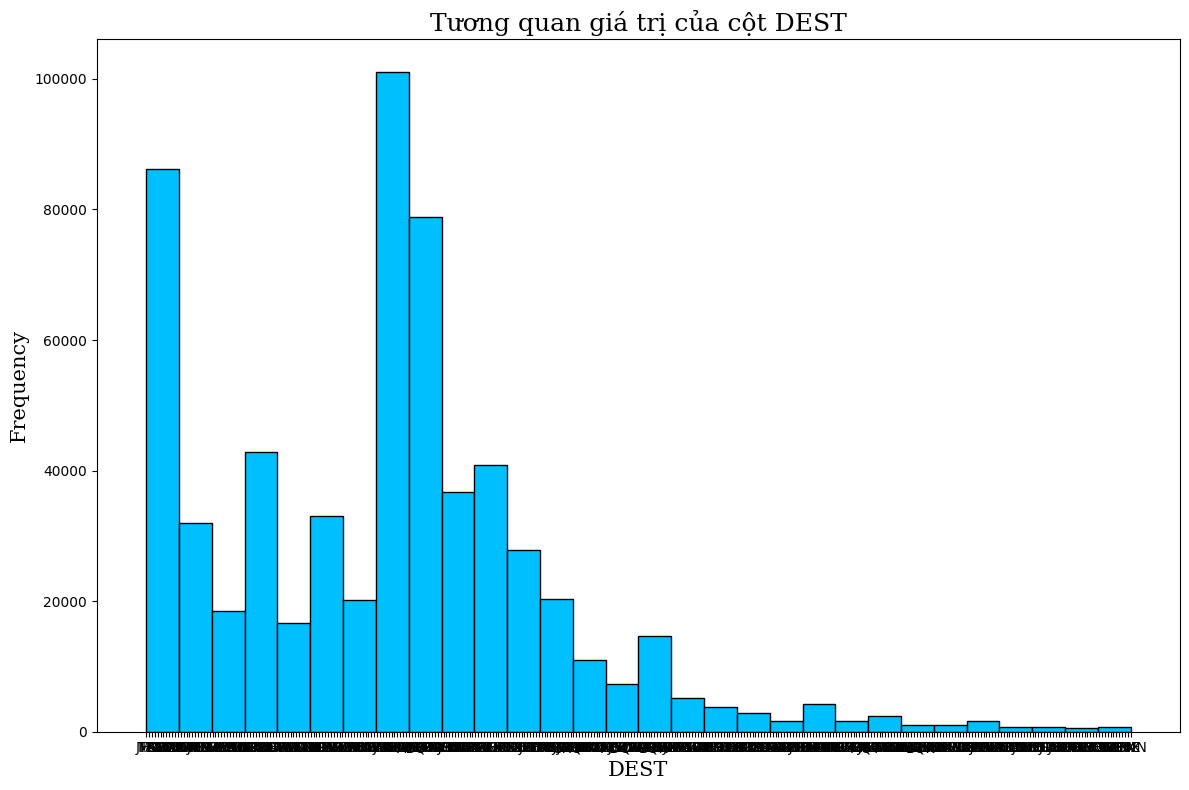

In [59]:
histogram_Plot_By_Col(dataset,'DEST')

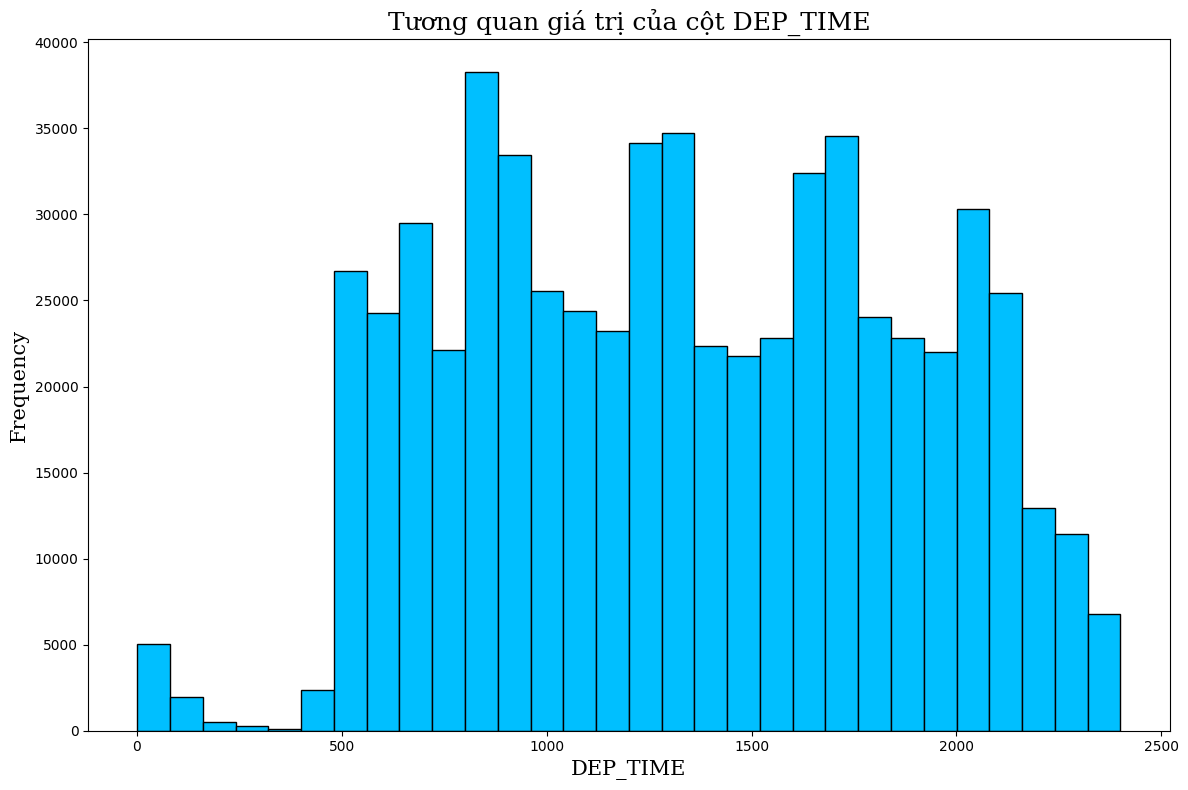

In [60]:
histogram_Plot_By_Col(dataset,'DEP_TIME')

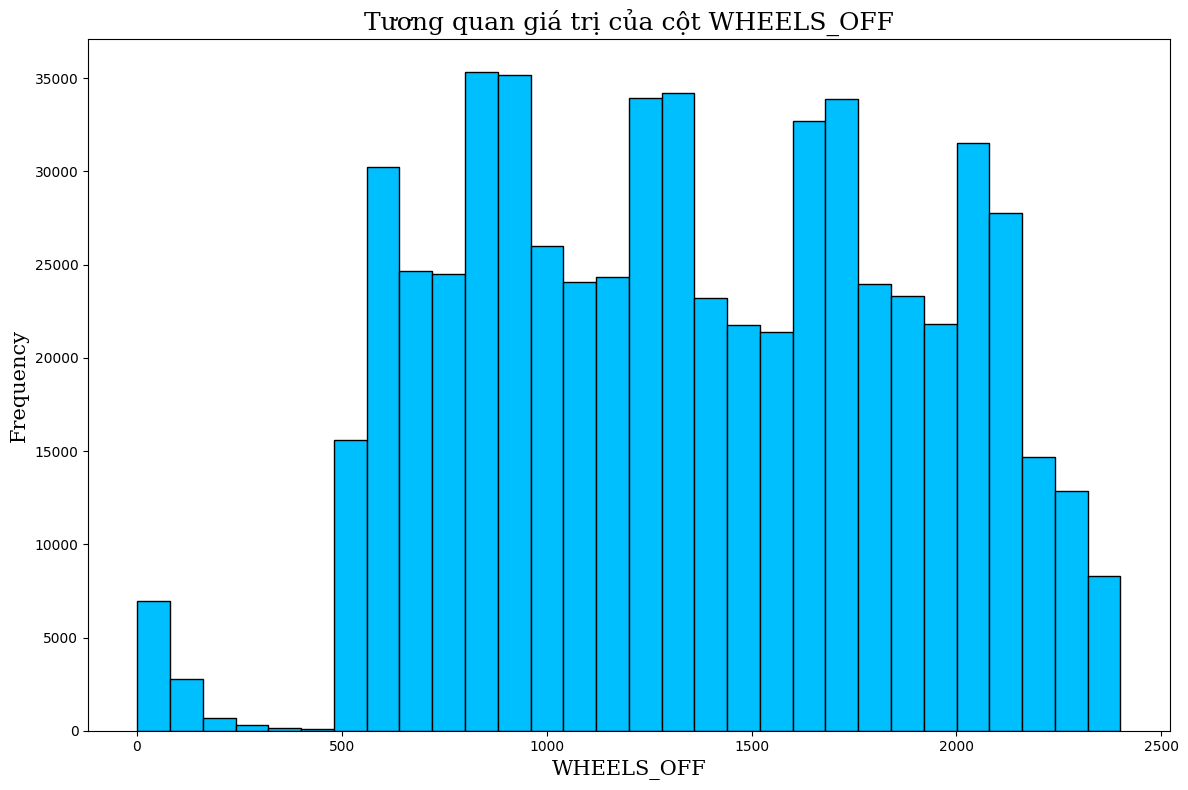

In [61]:
histogram_Plot_By_Col(dataset,'WHEELS_OFF')

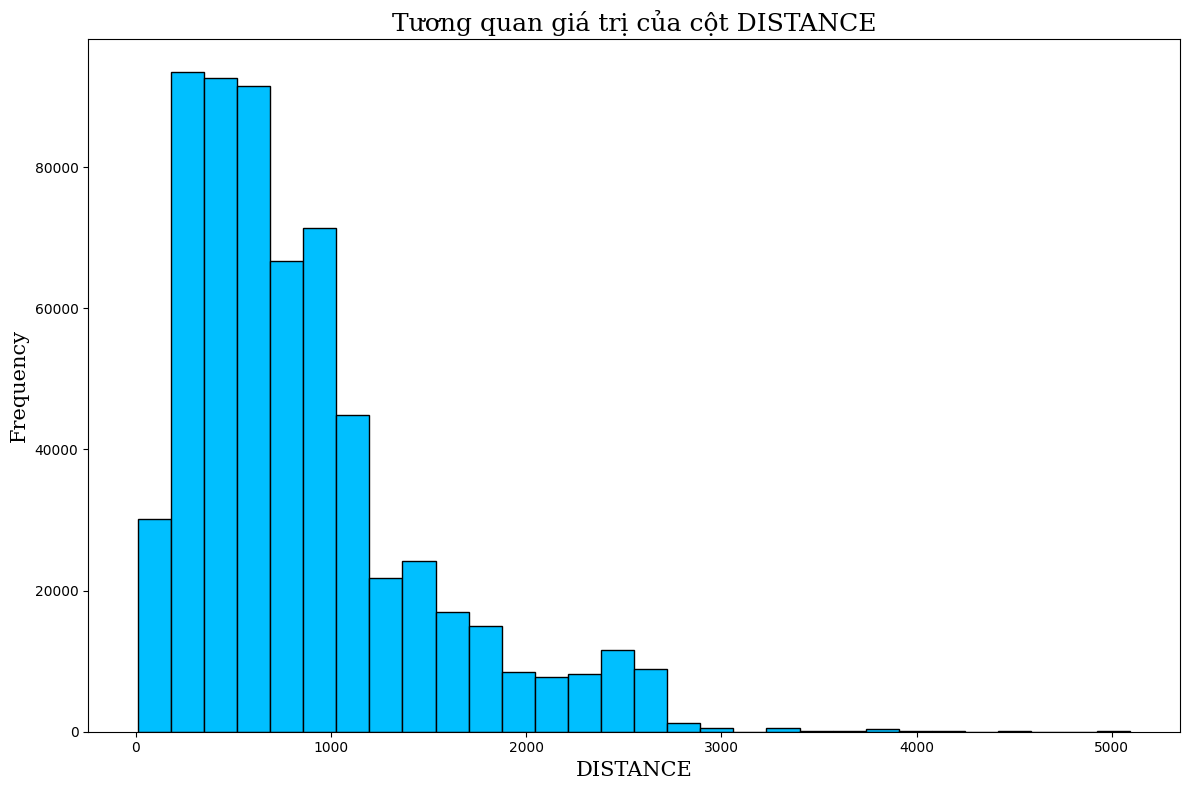

In [62]:
histogram_Plot_By_Col(dataset,'DISTANCE')

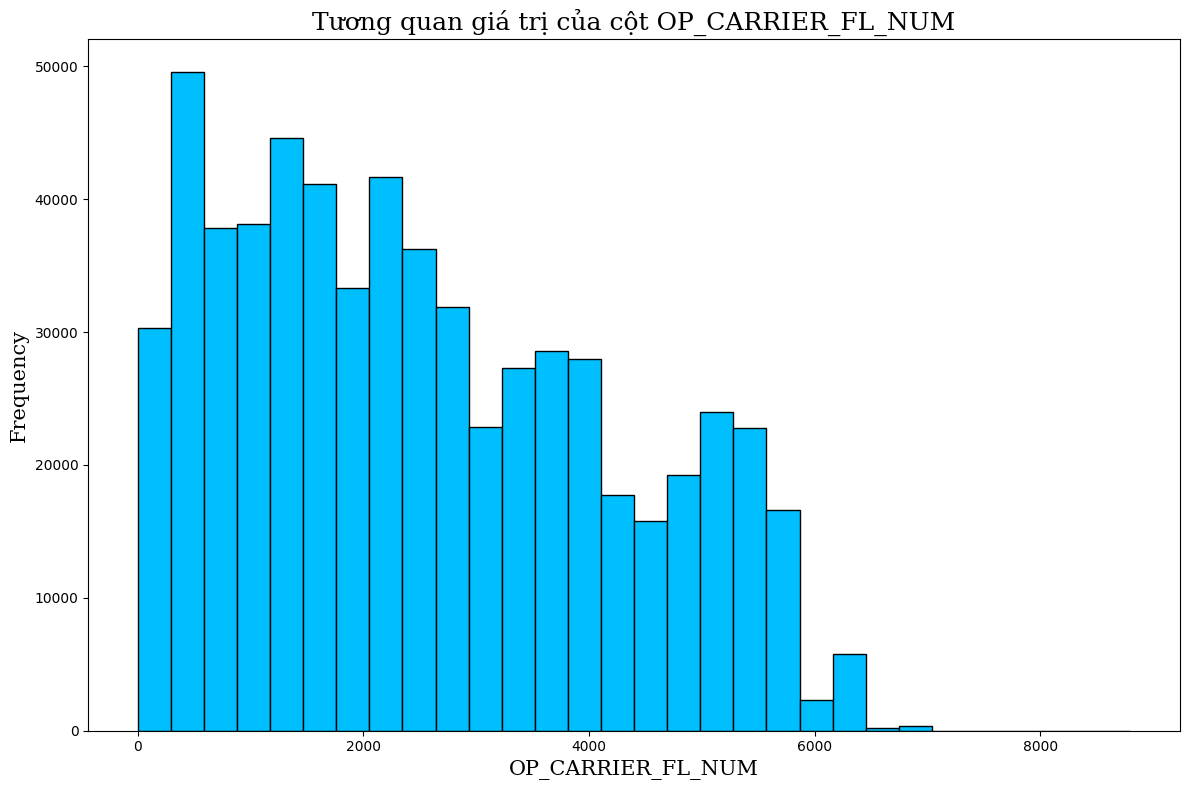

In [63]:
histogram_Plot_By_Col(dataset,'OP_CARRIER_FL_NUM')

In [64]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession
indexer_op_carrier = StringIndexer(inputCol='OP_UNIQUE_CARRIER', outputCol='OP_UNIQUE_CARRIERIndex')
indexer_origin = StringIndexer(inputCol='ORIGIN', outputCol='ORIGINIndex')
indexer_dest = StringIndexer(inputCol='DEST', outputCol='DESTIndex')

# Áp dụng StringIndexer cho từng cột
df_indexed = indexer_op_carrier.fit(dataset).transform(dataset)
df_indexed = indexer_origin.fit(df_indexed).transform(df_indexed)
df_indexed = indexer_dest.fit(df_indexed).transform(df_indexed)
df_indexed = df_indexed.drop('OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST')
df_indexed.describe().show()
df_indexed.show(10,False)

+-------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+----------------------+------------------+-----------------+
|summary|     DAY_OF_MONTH|       DAY_OF_WEEK| OP_CARRIER_FL_NUM|          DEP_TIME|          TAXI_OUT|        WHEELS_OFF|         DISTANCE|             LABEL|OP_UNIQUE_CARRIERIndex|       ORIGINIndex|        DESTIndex|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+----------------------+------------------+-----------------+
|  count|           616282|            616282|            616282|            616282|            616282|            616282|           616282|            616282|                616282|            616282|           616282|
|   mean|16.09324951888908|3.7845547979658662|2542.2255607011075|1338.7989702765942|18.170827640593107|1357.983424795791

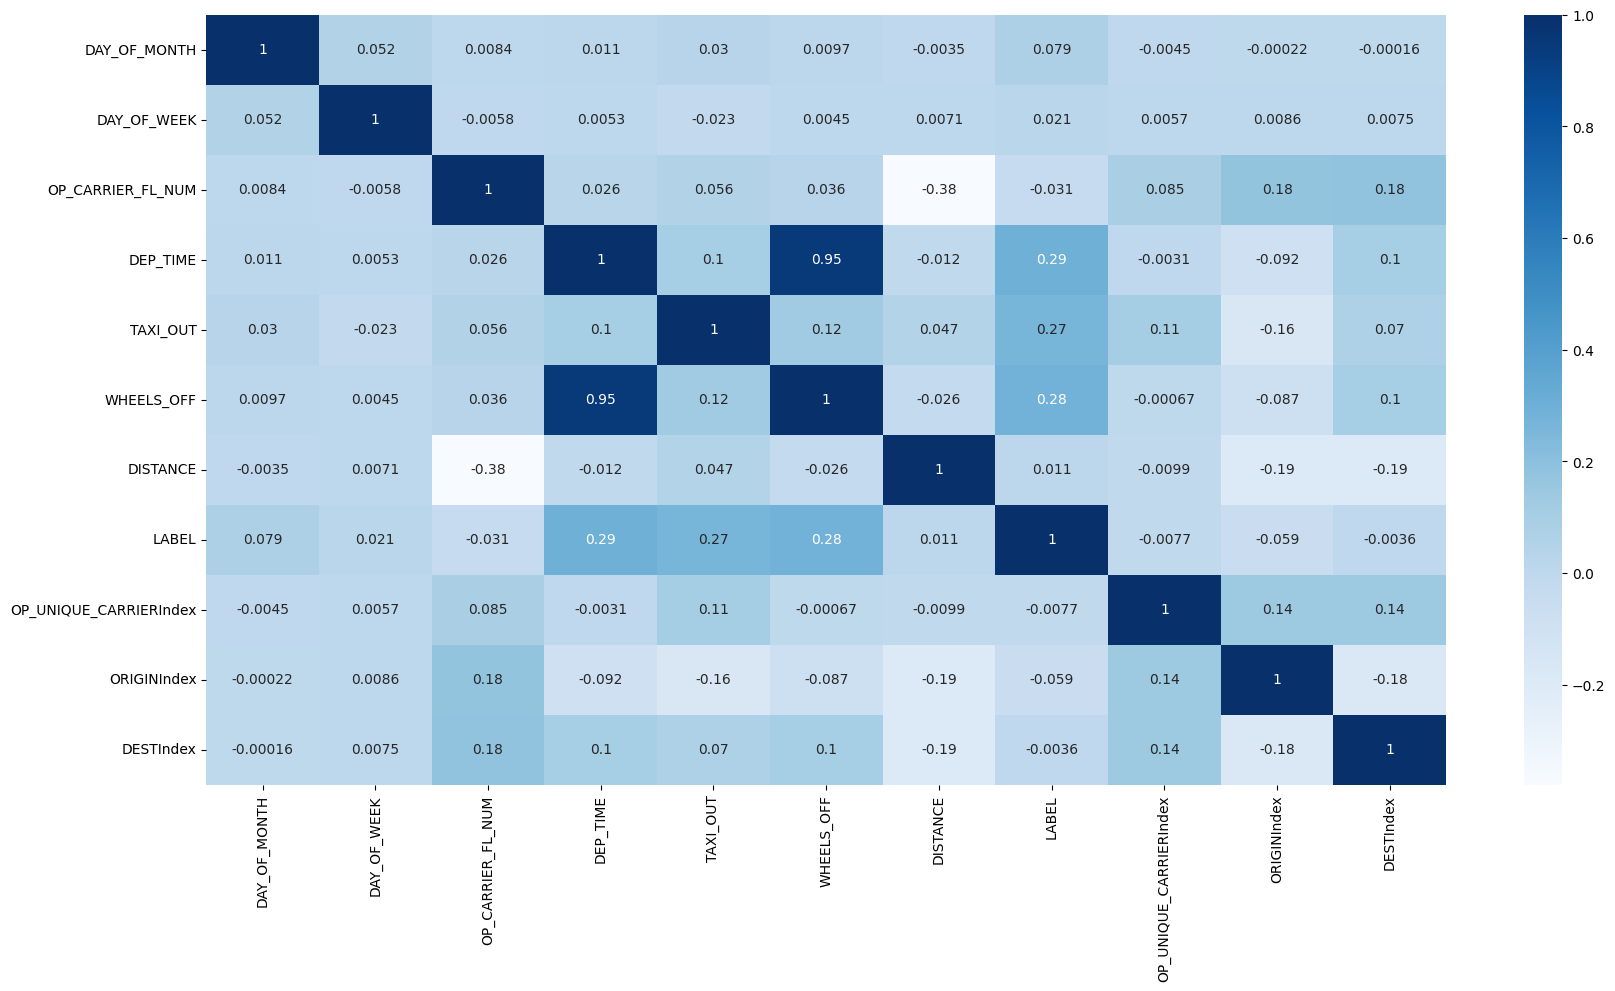

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

cor = df_indexed.toPandas().corr(method='pearson')

plt.figure(figsize=(20, 10))  # Điều chỉnh kích thước hình ảnh
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)

# Hiển thị heatmap
plt.show()

In [66]:
data = df_indexed.drop('WHEELS_OFF')
data.show(10,False)

+------------+-----------+-----------------+--------+--------+--------+-----+----------------------+-----------+---------+
|DAY_OF_MONTH|DAY_OF_WEEK|OP_CARRIER_FL_NUM|DEP_TIME|TAXI_OUT|DISTANCE|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|
+------------+-----------+-----------------+--------+--------+--------+-----+----------------------+-----------+---------+
|1           |1          |4800             |656     |14.0    |636.0   |0    |12.0                  |53.0       |17.0     |
|1           |1          |4801             |2056    |46.0    |227.0   |1    |12.0                  |1.0        |198.0    |
|1           |1          |4802             |1113    |25.0    |196.0   |1    |12.0                  |127.0      |14.0     |
|1           |1          |4802             |902     |26.0    |196.0   |0    |12.0                  |14.0       |127.0    |
|1           |1          |4803             |555     |21.0    |227.0   |0    |12.0                  |198.0      |1.0      |
|1           |1 

In [67]:
from pyspark.ml.feature import  OneHotEncoder

encoder_carrier = OneHotEncoder(inputCol="OP_UNIQUE_CARRIERIndex", outputCol="OP_UNIQUE_CARRIER_OneHot")
encoder_origin = OneHotEncoder(inputCol="ORIGINIndex", outputCol="ORIGIN_OneHot")
encoder_dest = OneHotEncoder(inputCol="DESTIndex", outputCol="DEST_OneHot")

# Áp dụng OneHotEncoder
df_encoded = encoder_carrier.fit(data).transform(df_indexed)
df_encoded = encoder_origin.fit(df_encoded).transform(df_encoded)
df_encoded = encoder_dest.fit(df_encoded).transform(df_encoded)
df_encoded.show(10,False)

+------------+-----------+-----------------+--------+--------+----------+--------+-----+----------------------+-----------+---------+------------------------+-----------------+-----------------+
|DAY_OF_MONTH|DAY_OF_WEEK|OP_CARRIER_FL_NUM|DEP_TIME|TAXI_OUT|WHEELS_OFF|DISTANCE|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIER_OneHot|ORIGIN_OneHot    |DEST_OneHot      |
+------------+-----------+-----------------+--------+--------+----------+--------+-----+----------------------+-----------+---------+------------------------+-----------------+-----------------+
|1           |1          |4800             |656     |14.0    |710       |636.0   |0    |12.0                  |53.0       |17.0     |(14,[12],[1.0])         |(341,[53],[1.0]) |(341,[17],[1.0]) |
|1           |1          |4801             |2056    |46.0    |2142      |227.0   |1    |12.0                  |1.0        |198.0    |(14,[12],[1.0])         |(341,[1],[1.0])  |(341,[198],[1.0])|
|1           |1          

In [68]:
from pyspark.ml.feature import VectorAssembler
assembler_all = VectorAssembler(inputCols=['DAY_OF_MONTH', 'TAXI_OUT', 'DEP_TIME', 'OP_CARRIER_FL_NUM', 'DAY_OF_WEEK',
                                           'OP_UNIQUE_CARRIER_OneHot', 'ORIGIN_OneHot', 'DEST_OneHot', 'DISTANCE'],
                                outputCol='features')

df_assembler = assembler_all.transform(df_encoded)
df_assembler.show(10,False)


+------------+-----------+-----------------+--------+--------+----------+--------+-----+----------------------+-----------+---------+------------------------+-----------------+-----------------+-------------------------------------------------------------------------------+
|DAY_OF_MONTH|DAY_OF_WEEK|OP_CARRIER_FL_NUM|DEP_TIME|TAXI_OUT|WHEELS_OFF|DISTANCE|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIER_OneHot|ORIGIN_OneHot    |DEST_OneHot      |features                                                                       |
+------------+-----------+-----------------+--------+--------+----------+--------+-----+----------------------+-----------+---------+------------------------+-----------------+-----------------+-------------------------------------------------------------------------------+
|1           |1          |4800             |656     |14.0    |710       |636.0   |0    |12.0                  |53.0       |17.0     |(14,[12],[1.0])         |(341,[53],[1.0]) 

In [69]:
dataset=df_assembler.select('features','LABEL')
dataset.show(10,False)

+-------------------------------------------------------------------------------+-----+
|features                                                                       |LABEL|
+-------------------------------------------------------------------------------+-----+
|(702,[0,1,2,3,4,17,72,377,701],[1.0,14.0,656.0,4800.0,1.0,1.0,1.0,1.0,636.0])  |0    |
|(702,[0,1,2,3,4,17,20,558,701],[1.0,46.0,2056.0,4801.0,1.0,1.0,1.0,1.0,227.0]) |1    |
|(702,[0,1,2,3,4,17,146,374,701],[1.0,25.0,1113.0,4802.0,1.0,1.0,1.0,1.0,196.0])|1    |
|(702,[0,1,2,3,4,17,33,487,701],[1.0,26.0,902.0,4802.0,1.0,1.0,1.0,1.0,196.0])  |0    |
|(702,[0,1,2,3,4,17,217,361,701],[1.0,21.0,555.0,4803.0,1.0,1.0,1.0,1.0,227.0]) |0    |
|(702,[0,1,2,3,4,17,175,361,701],[1.0,12.0,1756.0,4804.0,1.0,1.0,1.0,1.0,692.0])|0    |
|(702,[0,1,2,3,4,17,20,515,701],[1.0,14.0,2051.0,4805.0,1.0,1.0,1.0,1.0,692.0]) |0    |
|(702,[0,1,2,3,4,17,175,361,701],[1.0,19.0,601.0,4806.0,1.0,1.0,1.0,1.0,692.0]) |0    |
|(702,[0,1,2,3,4,17,95,375,701],

In [70]:
train, test = dataset.randomSplit(weights=[0.8, 0.2],seed=1)

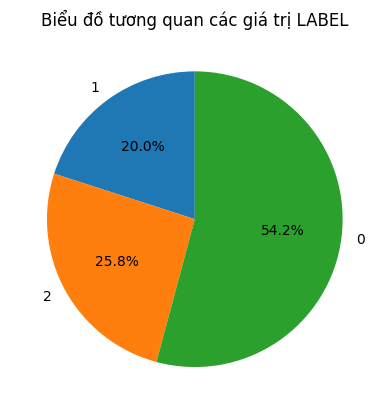

In [71]:
pie_Plot_By_Col(train,'LABEL')

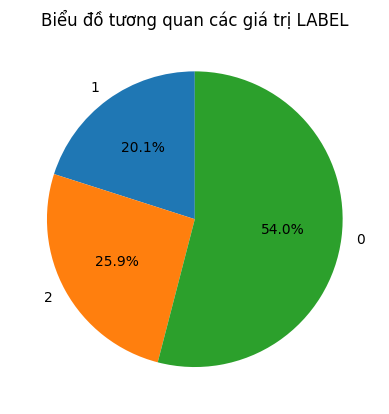

In [72]:
pie_Plot_By_Col(test,'LABEL')

In [73]:
train.toPandas().to_csv(r'/content/gdrive/MyDrive/Dataset/train_data.csv', index = False,header = True)
test.toPandas().to_csv(r'/content/gdrive/MyDrive/Dataset/test_data.csv', index = False,header = True)